# Customer Churn Analysis

## Setup

In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

# Models
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Save model
import pickle

# Set output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
## -- Functions - ##
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'Precison': metrics.precision_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
        'ROC_AUC': metrics.roc_auc_score(y_true, y_pred)
    }
    return dict_metrics

In [3]:
# Load data
df = pd.read_csv('../data/customer_churn.csv', index_col='CustomerID')
df.shape

(7032, 23)

## Data Understand

In [4]:
df.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV,Churn Value
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,3239,1
9237-HQITU,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,2701,1
9305-CDSKC,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,5372,1
7892-POOKP,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,5003,1
0280-XJGEX,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,5340,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude           7032 non-null   float64
 1   Longitude          7032 non-null   float64
 2   Gender             7032 non-null   object 
 3   Senior Citizen     7032 non-null   object 
 4   Partner            7032 non-null   object 
 5   Dependents         7032 non-null   object 
 6   Tenure Months      7032 non-null   int64  
 7   Phone Service      7032 non-null   object 
 8   Multiple Lines     7032 non-null   object 
 9   Internet Service   7032 non-null   object 
 10  Online Security    7032 non-null   object 
 11  Online Backup      7032 non-null   object 
 12  Device Protection  7032 non-null   object 
 13  Tech Support       7032 non-null   object 
 14  Streaming TV       7032 non-null   object 
 15  Streaming Movies   7032 non-null   object 
 16  Contract      

In [6]:
df.isna().sum()

Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
CLTV                 0
Churn Value          0
dtype: int64

In [7]:
df.nunique()

Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          72
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1584
Total Charges        6530
CLTV                 3435
Churn Value             2
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,7032.0,36.283307,2.456118,32.555828,34.030915,36.391777,38.227285,41.962127
Longitude,7032.0,-119.799215,2.157588,-124.301372,-121.815412,-119.735410,-118.043237,-114.192901
Tenure Months,7032.0,32.421786,24.545260,1.000000,9.000000,29.000000,55.000000,72.000000
Monthly Charges,7032.0,64.798208,30.085974,18.250000,35.587500,70.350000,89.862500,118.750000
Total Charges,7032.0,2283.300441,2266.771362,18.800000,401.450000,1397.475000,3794.737500,8684.800000
CLTV,7032.0,4401.445108,1182.414266,2003.000000,3469.750000,4527.500000,5381.000000,6500.000000
Churn Value,7032.0,0.265785,0.441782,0.000000,0.000000,0.000000,1.000000,1.000000


In [9]:
df.duplicated().any()

np.False_

In [10]:
# verificar desbalanceamento de dados
df['Churn Value'].value_counts()

Churn Value
0    5163
1    1869
Name: count, dtype: int64

In [11]:
# calcular desbalanceamento de dados
df['Churn Value'].eq(0).sum() / df.shape[0]

np.float64(0.7342150170648464)

Explicando o cálculo acima: 

* df['Churn Value'] -> seleciona somente a coluna target
* .eq(0).sum() -> soma somente os valores iguais a 0
* / df.shape[0] -> divide pela quantidade de linhas do dataset

O resultado pode ser multiplicado por 100 para ter o valor em porcentagem.

In [12]:
# Verificar a distribuição das classes diretamente
class_distribution = df['Churn Value'].value_counts(normalize=True) * 100
print("Distribuição das classes (%):")
print(class_distribution)

Distribuição das classes (%):
Churn Value
0    73.421502
1    26.578498
Name: proportion, dtype: float64


Geralmente os dados são considerados **desbalanceados quando** a classe minoritária representa **menos de 30% ou 20% do total**. 

Por exemplo:
* Classe minoritária com 30% (70%-30%): balanceado.
* Classe minoritária com 10% (90%-10%): desbalanceado.

## Data Preparation

In [13]:
df.columns


Index(['Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'CLTV', 'Churn Value'],
      dtype='object')

In [14]:
NUMERIC_FEATURES = [
    'Latitude',
    'Longitude',
    'Tenure Months',
    'Monthly Charges',
    'Total Charges',
    'CLTV'
]

CATEGORICAL_FEATURES = [
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'Churn Value'

In [15]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# pipeline pre-processador
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), NUMERIC_FEATURES),
    ('encoder', OneHotEncoder(drop='if_binary', sparse_output=False), CATEGORICAL_FEATURES)
])

Se houver uma variável categórica com apenas 2 categorias drop='if_binary' vai gerar apenas 1 nova coluna (não duas), ajudando o préprocessamento do modelo.

In [18]:
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Latitude', 'Longitude', 'Tenure Months',
                                  'Monthly Charges', 'Total Charges', 'CLTV']),
                                ('encoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Multiple Lines', 'Internet Service',
                                  'Online Security', 'Online Backup',
                                  'Device Protection', 'Tech Support',
                                  'Streaming TV', 'Streaming Movies',
                                  'Contract', 'Paperless Billing',
                                  'Payment Method'])])

In [19]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ['Latitude', 'Longitude', 'Tenure Months',
                                  'Monthly Charges', 'Total Charges', 'CLTV']),
                                ('encoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Multiple Lines', 'Internet Service',
                                  'Online Security', 'Online Backup',
                                  'Device Protection', 'Tech Support',
                                  'Streaming TV', 'Streaming Movies',
                                  'Contract', 'Paperless Billing',
                                  'Payment Method'])])

In [20]:
preprocessor.transform(X_train)

,scaler__Latitude,scaler__Longitude,scaler__Tenure Months,scaler__Monthly Charges,scaler__Total Charges,scaler__CLTV,encoder__Gender_Male,encoder__Senior Citizen_Yes,encoder__Partner_Yes,encoder__Dependents_Yes,...,encoder__Streaming Movies_No internet service,encoder__Streaming Movies_Yes,encoder__Contract_Month-to-month,encoder__Contract_One year,encoder__Contract_Two year,encoder__Paperless Billing_Yes,encoder__Payment Method_Bank transfer (automatic),encoder__Payment Method_Credit card (automatic),encoder__Payment Method_Electronic check,encoder__Payment Method_Mailed check
CustomerID,,,,,,,,,,,,,,,,,,,,,
6178-KFNHS,0.537594,-0.494247,-0.833469,0.444749,-0.607066,-0.737225,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1964-SVLEA,-0.879923,0.984306,-0.508058,-1.492135,-0.823672,-1.318265,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1791-PQHBB,0.960079,-0.489301,-1.240233,-0.120451,-0.950975,0.544458,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2522-WLNSF,-0.636470,-0.111127,0.061411,-0.021293,-0.081500,-1.856894,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2612-RANWT,-1.398112,1.547656,-0.833469,1.166949,-0.495086,-0.621016,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0696-UKTOX,-0.825728,0.603888,-0.386029,-0.353472,-0.430041,-1.627023,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5397-TUPSH,-0.995054,0.704942,1.322379,0.201812,0.993692,0.387535,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
8670-MEFCP,0.148684,-0.232730,0.142764,0.927318,0.477390,-0.716019,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [21]:
preprocessor.transform(X_test)

,scaler__Latitude,scaler__Longitude,scaler__Tenure Months,scaler__Monthly Charges,scaler__Total Charges,scaler__CLTV,encoder__Gender_Male,encoder__Senior Citizen_Yes,encoder__Partner_Yes,encoder__Dependents_Yes,...,encoder__Streaming Movies_No internet service,encoder__Streaming Movies_Yes,encoder__Contract_Month-to-month,encoder__Contract_One year,encoder__Contract_Two year,encoder__Paperless Billing_Yes,encoder__Payment Method_Bank transfer (automatic),encoder__Payment Method_Credit card (automatic),encoder__Payment Method_Electronic check,encoder__Payment Method_Mailed check
CustomerID,,,,,,,,,,,,,,,,,,,,,
7926-IJOOU,0.599432,-1.250799,-1.280909,-1.505356,-0.997800,1.027952,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7554-AKDQF,-0.854233,0.800632,-1.077527,-0.634419,-0.864262,-0.158728,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0013-SMEOE,-0.614868,-0.354013,1.566437,1.482602,2.464095,0.506288,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
9289-LBQVU,-1.030570,1.269975,1.281702,0.175370,0.960982,0.528342,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2348-KCJLT,-1.006154,0.796887,0.468175,-0.110535,0.188911,-1.997701,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0345-XMMUG,0.840700,-0.540986,0.549528,1.456160,1.125012,0.597897,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3996-ZNWYK,0.884630,-0.792318,1.566437,-1.488830,-0.396673,1.191661,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5222-IMUKT,0.491909,-0.205765,-0.019942,0.866170,0.254462,-1.440411,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Modeling and Evaluation


In [23]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyClassifier())
])

model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Latitude', 'Longitude',
                                                   'Tenure Months',
                                                   'Monthly Charges',
                                                   'Total Charges', 'CLTV']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Gender', 'Senior Citizen',
                                                   'Partner', 'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Internet Service',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('model', DummyClassifier())])

O DummyClassifier funciona como um 'chute' da categoria mais presente. Logo, qualquer modelo precisa ser melhor que ele para predição.

In [ ]:
params = {
    'model': [
        LogisticRegressionCV(max_iter=1_000),
        RandomForestClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        LGBMClassifier(random_state=42),
        DummyClassifier()
    ]
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')] # retirar colunas com o nome split ou fit para deixar a tabela abaixo mais enxuta

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,mean_score_time,std_score_time,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.064734,0.004519,LogisticRegressionCV(max_iter=1000),{'model': LogisticRegressionCV(max_iter=1000)},0.622946,0.006811
2,0.039161,0.005643,GradientBoostingClassifier(random_state=42),{'model': GradientBoostingClassifier(random_st...,0.611151,0.010543
3,0.042521,0.001904,LGBMClassifier(random_state=42),{'model': LGBMClassifier(random_state=42)},0.595491,0.018891
4,0.097129,0.011777,RandomForestClassifier(random_state=42),{'model': RandomForestClassifier(random_state=...,0.588500,0.009034
5,0.048419,0.006591,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000


* n_jobs=-1 -> para usar todos os núcleos dos processadores
* scoring='f1' -> métrica equilibrada entre precision e recall


In [29]:
# modelando com classes desbalanceadas
params = {
    'model': [
        LogisticRegressionCV(max_iter=1_000, class_weight='balanced'),
        RandomForestClassifier(random_state=2023, class_weight='balanced'),
        LGBMClassifier(is_unbalance=True, random_state=2023),
        DummyClassifier()
    ] 
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,mean_score_time,std_score_time,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.051629,0.009661,"LogisticRegressionCV(class_weight='balanced', ...",{'model': LogisticRegressionCV(class_weight='b...,0.643208,0.014417
2,0.036825,0.000083,"LGBMClassifier(is_unbalance=True, random_state...","{'model': LGBMClassifier(is_unbalance=True, ra...",0.628084,0.009364
3,0.080625,0.012451,RandomForestClassifier(class_weight='balanced'...,{'model': RandomForestClassifier(class_weight=...,0.579700,0.010405
4,0.043404,0.003388,DummyClassifier(),{'model': DummyClassifier()},0.000000,0.000000


In [30]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, max_iter=1_000))
])

params = {
    'preprocessor__scaler': [StandardScaler(), PowerTransformer()],
    'model__class_weight': ['balanced'],
    'model__C': [0.001, 0.01, 0.1],
}

grid = GridSearchCV(model_pipeline, params, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_preprocessor__scaler,params,mean_test_score,std_test_score
rank_test_score,,,,,,,,
1,0.078412,0.015311,0.100,balanced,PowerTransformer(),"{'model__C': 0.1, 'model__class_weight': 'bala...",0.649583,0.017021
2,0.082831,0.025262,0.100,balanced,StandardScaler(),"{'model__C': 0.1, 'model__class_weight': 'bala...",0.644673,0.016447
3,0.081787,0.032824,0.010,balanced,PowerTransformer(),"{'model__C': 0.01, 'model__class_weight': 'bal...",0.643650,0.019895
4,0.061364,0.004902,0.010,balanced,StandardScaler(),"{'model__C': 0.01, 'model__class_weight': 'bal...",0.642399,0.022095
5,0.096727,0.021194,0.001,balanced,PowerTransformer(),"{'model__C': 0.001, 'model__class_weight': 'ba...",0.636087,0.020795
6,0.071683,0.024907,0.001,balanced,StandardScaler(),"{'model__C': 0.001, 'model__class_weight': 'ba...",0.625877,0.017812


In [ ]:
# Capturar o melhor modelo
tuned_model = grid.best_estimator_

# Passar o modelo nos dados de teste
y_pred = tuned_model.predict(X_test)
get_metrics(y_test, y_pred)

{'Accuracy': 0.7545023696682465,
 'Balanced Accuracy': np.float64(0.7634411943074078),
 'Recall': np.float64(0.7825311942959001),
 'Precison': np.float64(0.525748502994012),
 'F1': np.float64(0.6289398280802292),
 'ROC_AUC': np.float64(0.7634411943074078)}

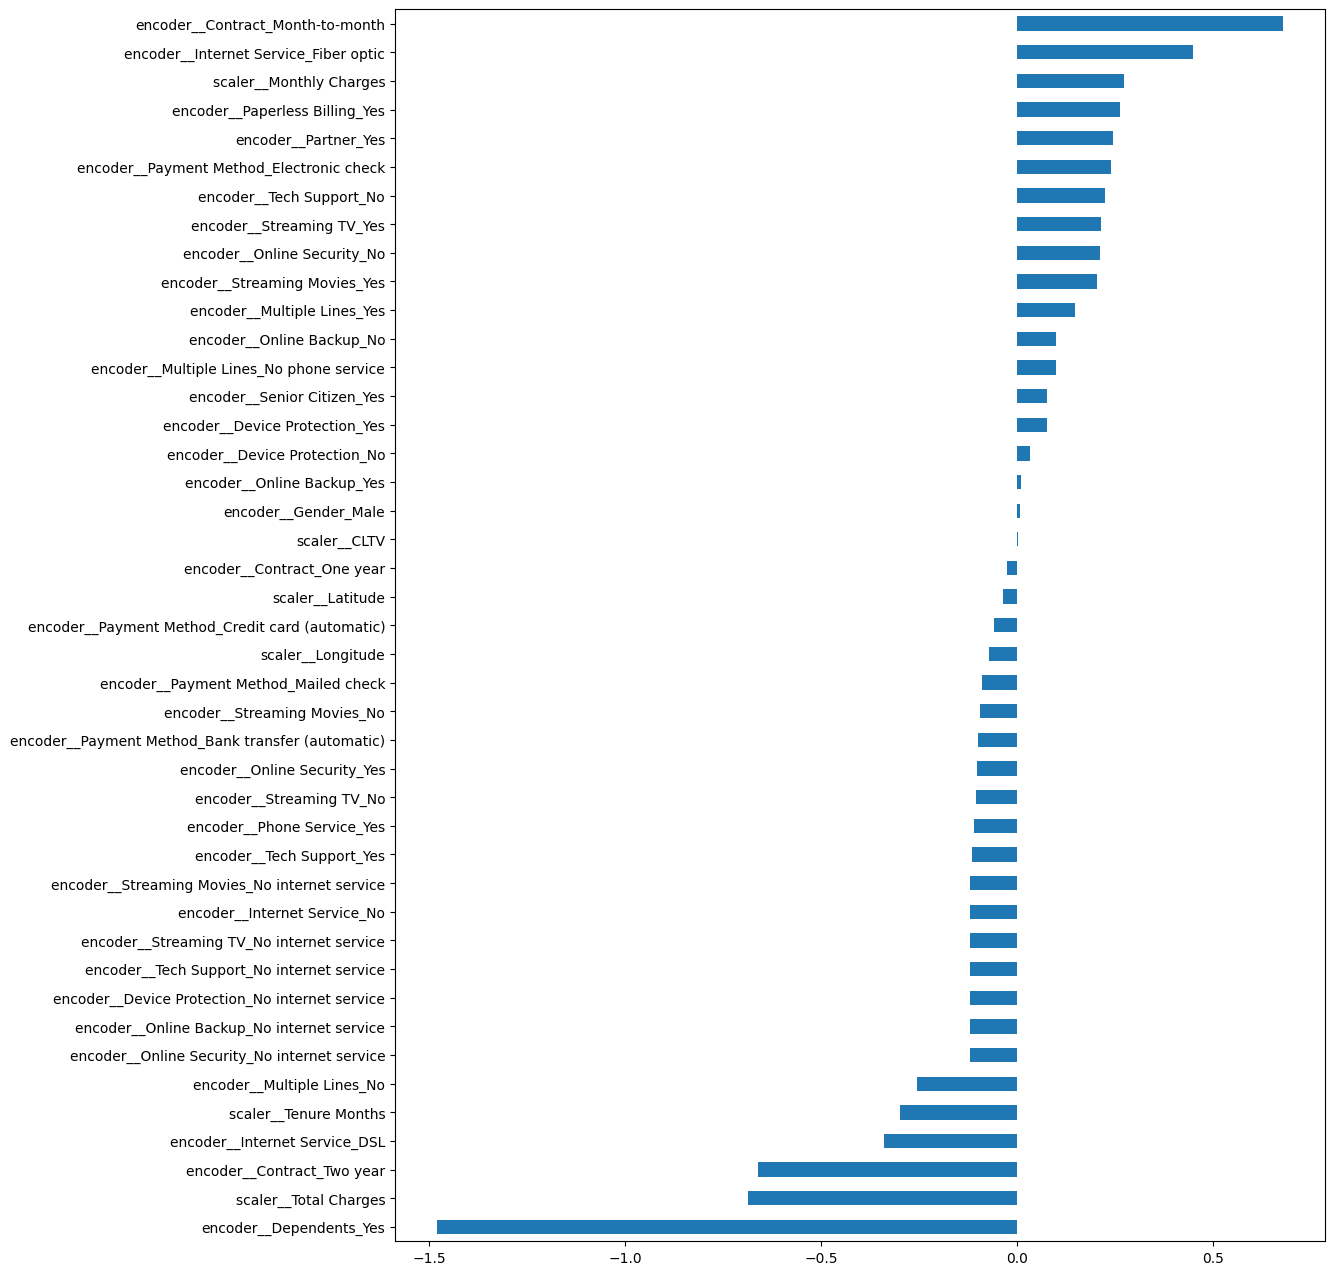

In [ ]:
lr_model = tuned_model.named_steps['model'] # capturando apenas a etapa de modelo do pipeline para acessar os coeficientes

coefs = pd.Series(
    data=lr_model.coef_[0], #acessar os coeficientes
    index=lr_model.feature_names_in_ # pegar o nome das variáveis que entraram no modelo
)

plt.figure(figsize=(12,16))
coefs.sort_values().plot.barh()
plt.show()

Interpretando o gráfico acima:
* Na presença da variável (valor positivo = 1), o índice inferior vai indicar se ele tem chance de ser churn ou não.

Exemplo:
* encoder_contract_month_to_month: valor aprox 0.70
* encoder_Dependents_yes: valor aprox de -1.5 indica que a presença dessa variável está mais ligada ao não-churn (valor negativo)

Ou seja, quanto mais à direita, maior a chance de ser churn (1, valor positivo), e quanto mais à esquerda menor a chance de ser churn (valor negativo).

## Deployment

In [38]:
with open('../models/churn_model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)